# Pre-processing pipeline

Notebook used to compute the pre-processing pipeline on the raw data coming from one deployment.

In [6]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../")
import importlib
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_function as theodo_f
import scripts.prediction_utils as prediction_u
import time
from tqdm import tqdm
import torch
from stheno.torch import B
import matplotlib.pyplot as plt

# Selection of datasets and pre-processing pipeline parameters

In [7]:
# Selection of files and parameters

# Path of the rosbags
file = [
        "/Volumes/T7/data/2023-07-25-14-53-26.bag",
        "/Volumes/T7/data/2023-07-25-15-14-57.bag",
        # "/Volumes/T7/data/2023-07-25-15-43-10.bag"
       ]

# Path of output
output = [
        "../data/20230725-1/",
        "../data/20230725-2/",
        # "../data/20230725-3/"
]

# Parameters to select:
# 1. Apply filtering or not on the total stations raw data (Module 1) (0 or 1)
# 2-3-4. Parameters tau_r(distance threshold m/s), tau_a(azimuth threshold deg/s), tau_e(elevation threshold deg/s) (Module 1)
# 5. Parameter tau_s(split mesurements s) (Module 2)
# 6. Parameter tau_l(interval of data keep between two trajectories s) (Module 3)
# 7. Parameter to cut edge of sub-intervals (former parameter with low impact s)
# parameters = [
#     [1,2,2,2,4,4,0],
# ]
parameters = [
    [1,2,2,2,3,6,0],
]

# Pre-processing pipeline

In [8]:
theodo_u = importlib.reload(theodo_u)
theodo_f = importlib.reload(theodo_f)
prediction_u = importlib.reload(prediction_u)
from pathlib import Path

for param in parameters:
    print(param)

    if(param[0]==0):
        filtering = False
    if(param[0]==1):
        filtering = True
    thresold_d = param[1]                # tau_r [m/s]
    thresold_a = param[2]                # tau_a [deg/s]
    thresold_e = param[3]                # tau_e [deg/s]
    limit_time_interval = param[4]       # tau_s [s]

    B.epsilon = 1e-8
    Mode = "L"       # Interpolation choice: 1. L -> Linear interpolation, 2. SGP -> Gaussian Process with Stheno library
    limit_search = limit_time_interval
    size_interval = param[5]         # tau_l [s]
    delta_t = param[6]               # Value to remove points near edge of time intervals [s]
    save = True

    # GP parameters
    verbose=False
    Number_restart = 100        # Number of restart for the GP
    noise_GP = 0                # Noise of GP
    variance_GP = 1             # Variance of GP
    lengthscale_GP = 1          # Lengthscale of GP

    save_index_1 = []
    save_index_2 = []
    save_index_3 = []

    for fname, opath in zip(file,output): 
        if(not filtering):
            path = opath + "raw_prediction/"
        else:
            path = opath + "filtered_prediction/"

        if(filtering):
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data_pre_filtered(fname, msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")
            index_1_f = theodo_u.thresold_raw_data(t1, d1, a1, e1, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_2_f = theodo_u.thresold_raw_data(t2, d2, a2, e2, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_3_f = theodo_u.thresold_raw_data(t3, d3, a3, e3, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            t1 = t1[index_1_f]
            t2 = t2[index_2_f]
            t3 = t3[index_3_f]
            tp1 = tp1[index_1_f].T
            tp2 = tp2[index_2_f].T
            tp3 = tp3[index_3_f].T
            print(len(t1),len(t2),len(t3))
        else:
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data(fname, msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")
            print(len(t1),len(t2),len(t3))

        time_origin = np.min([t1[0],t2[0],t3[0]])

        start_time = time.time()

        t1 = t1 - np.ones_like(t1)*time_origin
        t2 = t2 - np.ones_like(t2)*time_origin
        t3 = t3 - np.ones_like(t3)*time_origin

        list_interval, list_time = theodo_f.split_time_interval_all_data(t1, t2, t3, limit_time_interval)
        list_trajectories_split = theodo_f.merge_interval(list_interval, list_time, t1, t2, t3, limit_search)

        Prediction_1 = []
        Prediction_2 = []
        Prediction_3 = []
        T_prediction = []

        for i in tqdm(list_trajectories_split):

            index_1 = np.array([i[0,0],i[1,0]])
            index_2 = np.array([i[0,1],i[1,1]])
            index_3 = np.array([i[0,2],i[1,2]])

            save_index_1.append(index_1)
            save_index_2.append(index_2)
            save_index_3.append(index_3)

            if(filtering==True):
                index_1 = prediction_u.delta_t_function(index_1,t1,delta_t)
                index_2 = prediction_u.delta_t_function(index_2,t2,delta_t)
                index_3 = prediction_u.delta_t_function(index_3,t3,delta_t)

            begin = np.max([t1[index_1[0]], t2[index_2[0]], t3[index_3[0]]])
            end = np.min([t1[index_1[1]], t2[index_2[1]], t3[index_3[1]]])

            if(abs(end-begin)>size_interval and begin<end):

                rate = 5  #Hz
                T_prediction_init = torch.from_numpy(np.arange(begin, end, 1/rate))

                # Test done for Multiple Gaussian Process Output
                if(Mode == "MGPO" or Mode == "All"):
                    T_MGPO, S_MGPO = prediction_u.data_training_MGPO(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    m = prediction_u.training_MGPO(Number_restart, verbose, T_MGPO, S_MGPO)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_MGPO, P2_MGPO, P3_MGPO = prediction_u.unit_prediction_MGPO(i, m)
                        Prediction_1.append(P1_MGPO)
                        Prediction_2.append(P2_MGPO)
                        Prediction_3.append(P3_MGPO)

                # Gaussian process with GPy library
                if(Mode == "GP" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_GP(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = prediction_u.training_GP(Number_restart, verbose, T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = prediction_u.unit_prediction_GP(i, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                # Linear interpolation
                if(Mode == "L" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_L(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Prediction")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = prediction_u.linear_interpolation(T1, X1, Y1, Z1, T2, X2, Y2, Z2,T3, X3, Y3, Z3)

                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = prediction_u.linear_prediction(i, time_origin, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                # Gaussian process with Stheno library
                if(Mode=="SGP"):
                    prediction_value = T_prediction_init.numpy()
                    # Prepare data for training
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_GP_stheno(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    # Training for each axis
                    m_X1, v_X1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=X1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y1, v_Y1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Y1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z1, v_Z1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Z1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X2, v_X2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=X2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y2, v_Y2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Y2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z2, v_Z2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Z2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X3, v_X3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=X3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y3, v_Y3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Y3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z3, v_Z3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Z3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)

                    # Save prediction at time i
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X1, m_Y1, m_Z1, v_X1, v_Y1, v_Z1):
                        Prediction_1.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                        T_prediction.append(i+time_origin)
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X2, m_Y2, m_Z2, v_X2, v_Y2, v_Z2):
                        Prediction_2.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X3, m_Y3, m_Z3, v_X3, v_Y3, v_Z3):
                        Prediction_3.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))

        stop_time = time.time()
        print(stop_time - start_time)

        print("Interpolation finished !")

        if save:
            if(Mode == "MGPO" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "GP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "SGP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "L" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"

                if save:
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")

        print("Saved !")

[1, 2, 2, 2, 3, 6, 0]
Number of data for theodolites: [1625 1926 2018]
Bad measures: 1283
1478 1741 1828


100%|██████████| 25/25 [00:00<00:00, 155.51it/s]


Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.19331026077270508
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [2177 2454 2468]
Bad measures: 2513
2055 2312 2330


 41%|████      | 15/37 [00:00<00:00, 145.11it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 37/37 [00:00<00:00, 240.49it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
0.21370220184326172
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


# Display results

In [10]:
theodo_u = importlib.reload(theodo_u)

k = "../data/20230725-1/"
path_type = 'filtered_prediction/'
#path_file_type = 'nf-1-6-1-L_'
path_file_type = 'f-2-2-2-3-6-0-L_'

trimble_1 = theodo_u.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data(file[0], msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")

Number of data for theodolites: [1625 1926 2018]
Bad measures: 1283


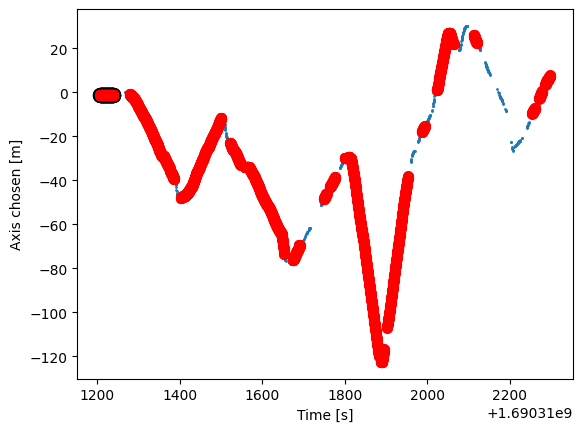

In [15]:
%matplotlib inline

save_index_1_arr = np.array(save_index_1)
i = save_index_1_arr[0]

plt.figure()

plt.scatter(t1,tp1[0,:],s =1)                                               # Raw data from rosbag
plt.scatter(t1[i[0]:i[1]],tp1[0,i[0]:i[1]], linewidth=5, color= 'black')      # Data given as input for the interpolation
plt.scatter(trimble_1[:,0],trimble_1[:,1], linewidth=2, color= 'red')       # Interpolated points
plt.xlabel("Time [s]")
plt.ylabel("Axis chosen [m]")


plt.show()